## Imports

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

os.chdir('../')

In [2]:
rawframes = 'data/wlasl/rawframes/test_depth/'
images = []
for video in os.listdir(rawframes):
    video_dir = rawframes+video
    for frame in os.listdir(video_dir):
        img = cv2.imread(os.path.join(video_dir,frame))
        if img is not None:
            images.append(img)

In [3]:
images = np.array(images)

In [4]:
images.shape

(472, 256, 256, 3)

## Load MiDaS

In [5]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/myuser1/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0

In [7]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/myuser1/.cache/torch/hub/intel-isl_MiDaS_master


In [8]:
images.shape

(472, 256, 256, 3)

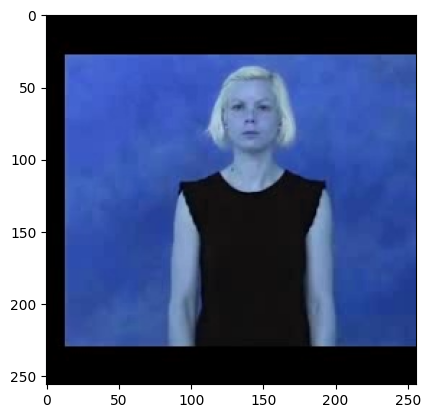

In [9]:
plt.imshow(images[0])

In [11]:
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

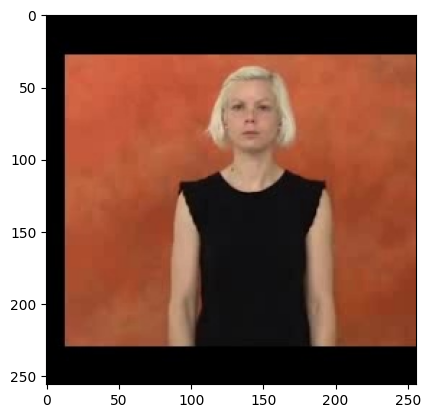

In [12]:
plt.imshow(images[0])

In [18]:
images.shape

(472, 256, 256, 3)

In [29]:
input_batch = transform(images[0])
for i in range(1, len(images)):
    input_batch = torch.concat((x, transform(images[i])), dim=0)

In [28]:
input_batch.shape

torch.Size([1, 3, 384, 384])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


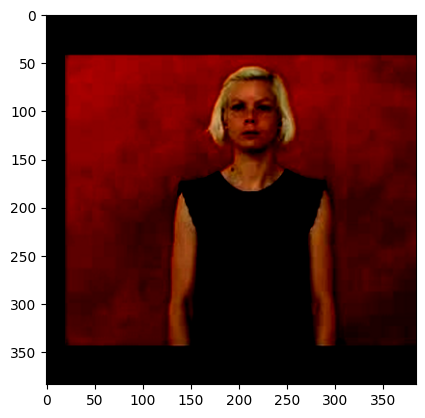

In [22]:
plt.imshow(input_batch[0].permute(1,2,0).cpu().numpy())

In [32]:
input_batch = input_batch.to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

prediction.shape

RuntimeError: CUDA out of memory. Tried to allocate 1.04 GiB (GPU 0; 9.78 GiB total capacity; 7.27 GiB already allocated; 90.25 MiB free; 7.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF